In [81]:
import csv
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import json
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error

## Cargar la información

In [109]:
train_housing_prices = pd.read_csv('train_precios_vivienda.csv', low_memory=False)
test_housing_prices = pd.read_csv('test_precios_vivienda.csv', low_memory=False)

# Preprocesamiento de la información

## Definir funciones importantes

In [39]:
def assign_uso_principal(string):

    residencial = ['VIVIEND', 'RESIDEN', 'HABIT', 'FAMIL']
    comercial = ['COMERC', 'OFIC', 'INDUS']
    institucional = ['INST', 'EDU']

    categorias = {}
    res = sum([1 for x in residencial if x in string ])
    com = sum([1 for x in comercial if x in string ])
    inst = sum([1 for x in institucional if x in string ])

    categorias['residencial'] = 0
    categorias['comercial'] = 0
    categorias['institucional'] = 0

    if res > 0:
        categorias['residencial'] = 1
    if com > 0:
        categorias['comercial'] = 1
    if inst > 0:
        categorias['institucional'] = 1
    
    return categorias

def rows_with_special_character(df):
    special_characters = r'[!@#$%^&*(),.?":{}|<>]'
    has_special_char = df.apply(lambda x: x.str.contains(special_characters).any(), axis=1)
    return df[has_special_char].drop_duplicates()

## Transformación de columnas

In [40]:
def preprocess_information(df, numeric_cols, delete_columns, replace_columns, keep_rows, delete_rows):
    
    #Transformaciones a algunas columnas
    df['uso_principal_ph'] = df['uso_principal_ph'] + df['rph'] + df['porteria']
    df['uso_principal_ph'] = df['uso_principal_ph'].str.upper()
    df['detalle_material'] = df['detalle_material'].str.replace('PÃ³rticos','Pórticos').str.replace('MamposterÃ­a','Mampostería')
    df['tipo_deposito'] = df['tipo_deposito'].replace('0', 'No disponible')

    #Arreglar las columnas numéricas
    for numeric_col in numeric_cols:
        try:
            df[numeric_col] = df[numeric_col].astype(float)
        except:
            df[numeric_col] = pd.to_numeric(df[numeric_col].fillna('0').str.replace(',', '.'), errors='coerce').fillna(0).astype(float)
            
    #Eliminar las columnas innecesarias
    df.drop(delete_columns, inplace=True, axis=1)

    #Reemplazar los valores por cada columna
    for columns in replace_columns.keys():
        for column in columns:
            df[column] = df[column].replace(replace_columns[columns])

    #Filtrado de valores por columna a valores posibles
    for column in keep_rows.keys():
        df = df[df[column].isin(keep_rows[column])]

    #Eliminación de filas con valores que no corresponden a los valores posibles
    for column in delete_rows.keys():
        df = df[~df[column].isin(delete_rows[column])]

    #Transformaciones adicionales
    df['uso_principal'] = df['uso_principal_ph'].apply(assign_uso_principal)
    df_exp = pd.json_normalize(df['uso_principal'])
    df = pd.concat([df, df_exp], axis=1)
    df.drop(columns=['uso_principal', 'uso_principal_ph'], inplace=True)

    n_antes = len(df)
    print('Longitud de los datos antes de eliminar nulos: {}'.format(n_antes))
    df = df.dropna()
    n_despues = len(df)
    porc_elim = round((abs(n_despues-n_antes)/n_antes)*100,2)
    print('Longitud de los datos despues de eliminar nulos: {}'.format(n_despues))
    print(f'La cantidad de datos borrados fue del {porc_elim} %')
    print()

    return df

In [41]:
numeric_cols = [
    'area_privada', 'valor_area_privada', 'area_garaje', 'valor_area_garaje', 'area_deposito', 'valor_area_deposito','area_terreno','valor_area_terreno',
    'area_construccion','valor_area_construccion','area_otros','valor_area_otros','area_libre','valor_area_libre', 'habitaciones', 'numero_total_depositos'
]

In [42]:
delete_columns = [
    'Unnamed: 0', 'direccion_inmueble_informe', 'descripcion_general_sector', 'perspectivas_de_valorizacion', 'actualidad_edificadora',
    'comportamiento_oferta_demanda', 'descripcion_tipo_inmueble', 'descripcion_uso_inmueble', 'descripcion_clase_inmueble', 'observaciones_altura_permitida',
    'observaciones_aislamiento_posterior', 'observaciones_aislamiento_lateral', 'observaciones_antejardin', 'observaciones_indice_ocupacion', 
    'observaciones_indice_construccion', 'observaciones_generales_inmueble', 'condicion_ph', 'observaciones_estructura', 'observaciones_dependencias', 
    'numero_garaje_1', 'numero_garaje_2', 'numero_garaje_3', 'numero_garaje_4', 'numero_garaje_5', 'matricula_garaje_1', 'matricula_garaje_2',
    'matricula_garaje_3', 'matricula_garaje_4', 'matricula_garaje_5', 'numero_deposito_1', 'matricula_inmobiliaria_deposito_1', 'numero_deposito_2',
    'matricula_inmobiliaria_deposito_2', 'numero_deposito_3', 'matricula_inmobiliaria_deposito_3', 'numero_deposito_4', 'matricula_inmobiliaria_deposito_4',
    'numero_deposito_5', 'matricula_inmobiliaria_deposito_5', 'observaciones_generales_construccion', 'metodo_valuacion_1', 'metodo_valuacion_1', 'concepto_del_metodo_1',
    'metodo_valuacion_2','concepto_del_metodo_2','metodo_valuacion_3','concepto_del_metodo_3','metodo_valuacion_4','concepto_del_metodo_4','metodo_valuacion_5',
    'concepto_del_metodo_5', 'metodo_valuacion_6', 'concepto_del_metodo_6', 'metodo_valuacion_7', 'concepto_del_metodo_7', 'metodo_valuacion_8', 'concepto_del_metodo_8',
    'metodo_valuacion_9', 'concepto_del_metodo_9', 'barrio', 'unidades', 'garaje_paralelo_4', 'garaje_doble_5', 'garaje_paralelo_5', 'garaje_servidumbre_5', 'area_libre',
    'tipo_subsidio', 'fecha_aprobación', 'valor_uvr', 'valor_avaluo_en_uvr'
]

In [43]:
replace_columns = {
    ('objeto',): {
       'OriginaciÃ³n':'Originación' 
    },
    ('motivo',): {
        'CrÃ©dito hipotecario de vivienda': 'Crédito hipotecario de vivienda',
        'Dación en Pago': 'DaciÃ³n en Pago',
        'ActualizaciÃ³n de garantÃ­as':'Actualización de garantías',
        'CrÃ©dito Comercial':'Crédito Comercial',
        'ActualizaciÃ³n de garantÃ\xadas Leasing': 'Actualización de garantías'
    },
    ('proposito',): {
        'GarantÃ­a Hipotecaria': 'Garantía Hipotecaria',
        'TransacciÃ³n Comercial de Venta': 'Transacción Comercial de Venta',
        'TransacciÃ³n Comercial de Renta': 'Transacción Comercial de Venta'
    },
    ('garaje_cubierto_1', 'garaje_doble_1', 'garaje_paralelo_1', 'garaje_servidumbre_1', 'garaje_cubierto_2', 'garaje_doble_2', 'garaje_paralelo_2',
     'garaje_servidumbre_2', 'garaje_cubierto_3', 'garaje_doble_3', 'garaje_paralelo_3', 'garaje_servidumbre_3', 'garaje_cubierto_4', 'garaje_doble_4',
     'garaje_servidumbre_4', 'garaje_cubierto_5', 'acueducto_en_el_predio', 'gas_en_el_predio', 'energia_en_el_predio', 'telefono_en_el_predio', 
     'predio_subdividido_fisicamente', 'rph', 'porteria', 'citofono', 'bicicletero', 'piscina', 'tanque_de_agua', 'club_house', 'garaje_visitantes', 
     'teatrino', 'sauna', 'vigilancia_privada', 'tipo_vigilancia', 'administracion'): {
        '0': 'No',
        '1': 'Si',
    },
    ('departamento_inmueble',):{
        'BOGOTÃ, D. C.': 'BOGOTÁ, D. C.',
        'BOLÃVAR': 'BOLÍVAR',
        'ATLÃNTICO':'ATLÁNTICO',
        'CÃ“RDOBA':'CÓRDOBA',
        'BOYACÃ':'BOYACÁ',
        'QUINDÃO':'QUINDÍO',
        'NARIÃ‘O':'NARIÑO',
        'CAQUETÃ':'CAQUETÁ',
        'GUAINÃA':'GUAINÍA',
        'CHOCÃ“':'CHOCÓ',
        'ARCHIPIÃ‰LAGO DE SAN ANDRÃ‰S, PROVIDENCIA Y':'ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y',
    },
    ('municipio_inmueble',):{
        'BOGOTÃ, D. C.': 'BOGOTÁ, D. C.',
    },
    ('demanda_interes',): {
        'DÃ©bil': 'Débil',
    },
    ('uso_actual',): {
        '0': 'Otro',
        'Ind. QuÃ­mica': 'Ind. Quí­mica',
        'EducaciÃ³n':'Educación'
    },
    ('clase_inmueble',): {
        '0': 'Otro'
    },
    ('altura_permitida', 'aislamiento_posterior', 'aislamiento_lateral', 'antejardin', 'indice_ocupacion', 'indice_construccion'):{
        '0': 'No Aplica'
    },
    ('uso_principal_ph',): {
        'RESIDENCIAL.': 'RESIDENCIAL',
        'RESIDENCAIL.': 'RESIDENCIAL',
        'VVIENDA': 'VIVIENDA',
        'VIVENDA': 'VIVIENDA',
        'VIVIENDA.': 'VIVIENDA',
        'VVIIENDA': 'VIVIENDA',
        'VIIVENDA': 'VIVIENDA',
        'VVIVIENDA': 'VIVIENDA',
        'VIVIENDAS': 'VIVIENDA',
        'RESIDECNIAL': 'RESIDENCIAL',
        'VIVIVENDA': 'VIVIENDA',
        'VIVINEDA': 'VIVIENDA',    
        'VIVIENDDA': 'VIVIENDA',
        'VIVIWENDA': 'VIVIENDA',
        'VIVIIENDA': 'VIVIENDA',
        'RESIDENCAIL': 'RESIDENCIAL',
        'MIXTA': 'MIXTO',
        'REISIDENCIAL':'RESIDENCIAL',
        'RESODENCIAL':'RESIDENCIAL',
        'USO RESIDENCIAL':'RESIDENCIAL',
        'RSIDENCIAL':'RESIDENCIAL',
        'RESIDENCIAL - TURÃ­STICO': 'RESIDENCIAL - TURISMO',
        'VIVIENDA Y RECREACIÃ³N': 'VIVIENDA Y RECREACIÓN',
        'REISDENCIAL': 'RESIDENCIAL',
        'VIVIEND': 'VIVIENDA',
        'VIVIEDA': 'VIVIENDA',
        'VIVIENADA': 'VIVIENDA',
        'VIVINDA': 'VIVIENDA',
        'VIIVIENDA': 'VIVIENDA',
        'VIVIEMDA': 'VIVIENDA',
        'VIVVIENDA': 'VIVIENDA',
        'RESIDECIAL': 'RESIDENCIAL',
        'RESIENCIAL': 'RESIDENCIAL',
        'RESIDENCIA': 'RESIDENCIAL',
        'RESIDNECIAL':'RESIDENCIAL',
        'REIDENCIAL':'RESIDENCIAL',
        'REDIDENCIAL': 'RESIDENCIAL',
    },
    ('estructura',): {
        '1': 'Otros',
        '2': 'Otros',
    },
    ('cubierta',): {
        'Teja metÃ¡lica': 'Teja metálica',
        'Teja plÃ¡stica': 'Teja plástica',
    },
    ('fachada',):{
        'PaÃ±ete y pintura': 'Pañete y pintura'
    },
    ('danos_previos',): {
        'Sin daÃ±os previos': 'Sin daños previos',
        'Con daÃ±os previos': 'Con daños previos'
    },
    ('material_de_construccion',): {
        'MamposterÃ­a': 'Mampostería'
    },
    ('detalle_material',): {
        '0': 'No disponible'    
    }
}

In [44]:
keep_rows = {
    'alcantarillado_en_el_predio': ['Si', 'No'],
    'rph': ['No', 'Si'],
    'estado_acabados_pisos': ['Bueno', 'Sin acabados', 'Regular', 'Malo'],    
}

In [45]:
delete_rows = {
    'objeto':['2018-06-19 19:48:27.269-05'],
    'motivo': ['0'],
    'proposito': ['0'],
    'departamento_inmueble': ['Ochoa Vahos Alba del Carmen', 'Rios Duque Sandra Rafaela','Velasquez Chica Enit Juliet','Franco Emilio Ayala', 
                              'Andres Felipe Orozco Vasquez', 'Anatilde Toro Echavarria', 'Lara Gomez Miguel Eduardo', 'Alicia Maria Velez Restrepo'],
    'sector': ['LOS GIRASOLES'],
    'estrato': ['Comercial', 'Industrial', 'Oficina'],
    'tipo_inmueble': ['0'],
    'ocupante': ['10 pisos', 'contador de tres alcobas c/u', '0'],
    'pisos_bodega': ['2017'],
    'ajustes_sismoresistentes': ['Mamposteria Estructural', 'Muro de carga', 'Tradicional'], 
    'garaje_cubierto_1': ['50C-1731779']
}

## Preprocesamiento de features

In [46]:
train_housing_prices_proc = preprocess_information(train_housing_prices, numeric_cols, delete_columns, replace_columns, keep_rows, delete_rows)
test_housing_prices_proc = preprocess_information(test_housing_prices, numeric_cols, delete_columns, replace_columns, keep_rows, delete_rows)

Longitud de los datos antes de eliminar nulos: 11564
Longitud de los datos despues de eliminar nulos: 11052
La cantidad de datos borrados fue del 4.43 %

Longitud de los datos antes de eliminar nulos: 1286
Longitud de los datos despues de eliminar nulos: 1235
La cantidad de datos borrados fue del 3.97 %



In [47]:
len(train_housing_prices_proc.columns)-len(test_housing_prices_proc.columns)

0

## Definir el tipo de Feature: 
- Categorica
- Numerica

In [60]:
def identify_feature_types(df, cat_features, num_features, threshold_unique):
    categorical_features = []
    numerical_features = []

    for col in df.columns:
        if col not in  ['valor_total_avaluo', 'id']:
            n = len(df[col].unique())
            if (n <= threshold_unique or col in cat_features) and col not in num_features:
                categorical_features.append([col, n])
            elif (n > threshold_unique or col in num_features) and col not in cat_features:
                numerical_features.append([col, n])

    return categorical_features, numerical_features

In [61]:
cat_features = [
    'departamento_inmueble', 'municipio_inmueble'
]
num_features = [
    'habitaciones', 'closet', 'bano_privado', 'sala', 'comedor', 'bano_social', 'cocina', 'zona_de_ropas', 'contadores_agua', 'accesorios',
    'patio_interior', 'contadores_luz', 'balcon', 'terraza', 'oficina', 'total_cupos_parquedaro', 'estrato', 'bano_servicio', 'numero_total_de_garajes',
    'local', 'estar_habitacion', 'jardin', 'numero_total_depositos', 'cuarto_servicio', 'pisos_bodega', 'bodega'
]
threshold_unique = 40

categorical_features, numerical_features = identify_feature_types(train_housing_prices_proc, cat_features, num_features, threshold_unique)

Dividir el conjunto de datos de entrenamiento en entrenamiento y validación.

## Tranformar las features

In [62]:
categorical_features = [x[0] for x in categorical_features]
numerical_features = [x[0] for x in numerical_features]

In [63]:
for col in numerical_features:
    try:
        test_housing_prices_proc[col] = test_housing_prices_proc[col].astype(float)
        train_housing_prices_proc[col] = train_housing_prices_proc[col].astype(float)
    except:
        test_housing_prices_proc[col] = test_housing_prices_proc[col].str.replace(',', '.')
        test_housing_prices_proc[col] = pd.to_numeric(test_housing_prices_proc[col], errors='coerce').fillna(0).astype(float)

        train_housing_prices_proc[col] = train_housing_prices_proc[col].str.replace(',', '.')
        train_housing_prices_proc[col] = pd.to_numeric(train_housing_prices_proc[col], errors='coerce').fillna(0).astype(float)

for col in categorical_features:
    test_housing_prices_proc[col] = test_housing_prices_proc[col].astype(str)

In [64]:
features = [x for x in train_housing_prices_proc.columns if x not in ['valor_total_avaluo', 'id']]

X_train, y_train = train_housing_prices_proc[features], train_housing_prices_proc['valor_total_avaluo']
y_train = y_train.str.replace(',', '.').astype(float)

In [65]:
X_test, y_test = test_housing_prices_proc, test_housing_prices_proc['valor_total_avaluo']
y_test = y_test.str.replace(',', '.').astype(float)

In [66]:
# Create a pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Create a pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Use ColumnTransformer to apply the appropriate preprocessing for each feature type
preprocessor = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features),
    ('numerical', numerical_pipeline, numerical_features)
])

#Obtener los nombres de las caracteristicas
feature_names = preprocessor.get_feature_names_out()

# Fit the preprocessor on the training data and transform both training and test data
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test[features])

## Generar los modelos

Se genera una busqueda usando un RandomizedSearch. Se iteran diferentes hiperparámetros para los diferentes modelos escogidos

In [22]:
# Define a dictionary to store search results
model_search_results = {}

# Define a list of models to perform random search on
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'XGBoost Regressor': XGBRegressor()
}

# Hyperparameters to search over for each model
param_distributions = {
    'Linear Regression': {'fit_intercept': [True, False]},
    'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Lasso Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'ElasticNet Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]},
    'Decision Tree Regressor': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest Regressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting Regressor': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'Support Vector Regressor': {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf']},
    'K-Nearest Neighbors Regressor': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'XGBoost Regressor': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]}
}

# Perform random search for each model
for model_name, model in tqdm(models.items()):
    search = RandomizedSearchCV(model, param_distributions[model_name], n_iter=20, 
                                scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                                cv=5, n_jobs=-1)
    search.fit(X_train_enc, y_train)
    y_pred = search.predict(X_test_enc)
    model_search_results[model_name] = {
        'best_params': search.best_params_,
        'test_MAPE': mean_absolute_percentage_error(y_test, y_pred)
    }

 80%|████████  | 8/10 [1:11:05<25:21, 760.62s/it]   File "c:\Users\Dani\anaconda3\envs\DL\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Dani\anaconda3\envs\DL\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Dani\anaconda3\envs\DL\lib\subprocess.py", line 969, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Dani\anaconda3\envs\DL\lib\subprocess.py", line 1438, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
100%|██████████| 10/10 [1:47:31<00:00, 645.17s/it]


## Transformar Resultados

In [35]:
results = []
for key in model_search_results.keys():
    row = [key, model_search_results[key]['best_params'], model_search_results[key]['test_MAPE']]
    results.append(row)

df_results = pd.DataFrame(data=results, columns=['Model', 'Best Parameters', 'Test MAPE'])
df_results['Test MAPE'] = df_results['Test MAPE'].apply(lambda x: format(float(x), ".4f"))
df_results.sort_values('Test MAPE')

,Model,Best Parameters,Test MAPE
4,Decision Tree Regressor,"{'min_samples_split': 5, 'max_depth': None}",0.0253
8,K-Nearest Neighbors Regressor,"{'weights': 'distance', 'n_neighbors': 3}",0.4544
1,Ridge Regression,{'alpha': 0.1},12142074727137233862656.0000
7,Support Vector Regressor,"{'kernel': 'poly', 'C': 10}",1289898539321678364672.0000
0,Linear Regression,{'fit_intercept': False},13155713727079924105216.0000
2,Lasso Regression,{'alpha': 10},14509133480357703712768.0000
5,Random Forest Regressor,"{'n_estimators': 200, 'max_depth': 10}",1595323155893107032064.0000
6,Gradient Boosting Regressor,"{'n_estimators': 200, 'learning_rate': 0.2}",3725716016990579589120.0000
9,XGBoost Regressor,"{'n_estimators': 300, 'learning_rate': 0.1}",67876243373772980224.0000
3,ElasticNet Regression,"{'l1_ratio': 0.1, 'alpha': 0.1}",9717731045727866454016.0000


## Generación de archivo de predicciones

In [70]:
best_model = DecisionTreeRegressor(min_samples_split= 5, max_depth= None)
best_model.fit(X_train_enc, y_train)

DecisionTreeRegressor(min_samples_split=5)

In [73]:
prediction_filename = 'predict_prices.csv'
X_test['prediction'] = best_model.predict(X_test_enc)
X_test[['id', 'prediction']].to_csv(prediction_filename)

## Mostrar las features mas importantes para el modelo

In [104]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df['importance'] = importance_df['importance'].apply(lambda x: format(float(x), ".10f"))
most_important_features = importance_df.sort_values(by='importance', ascending=False).head(20)
most_important_features['importance']= most_important_features['importance'].astype(float)

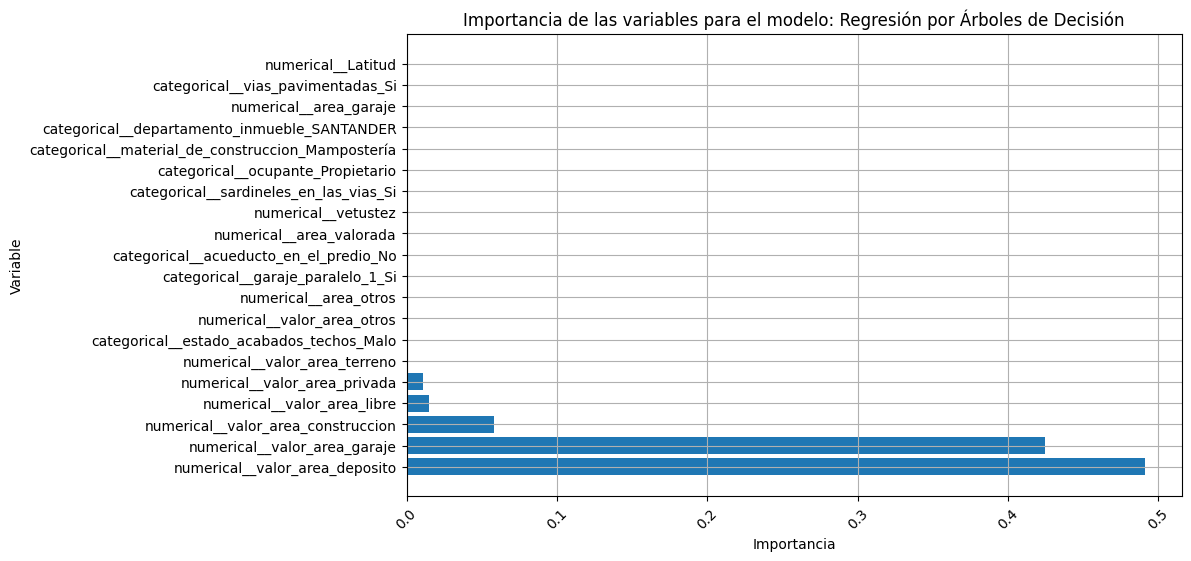

In [114]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(most_important_features['feature'], most_important_features['importance'])
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de las variables para el modelo: Regresión por Árboles de Decisión')
plt.xticks(rotation=45)
plt.grid()
plt.show()